In [1]:
import os
import sys
import glob
from collections import defaultdict, Counter
from functools import reduce, partial
from multiprocessing import Pool
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from scipy.stats import bootstrap, binom_test
from statsmodels.stats.multitest import multipletests
from scipy.spatial.distance import cosine, euclidean
from Bio import SeqIO
import tqdm

from pymutspec.draw import plot_mutspec12, plot_mutspec192
from pymutspec.annotation import rev_comp, CodonAnnotation, transcriptor, mutations_summary
from pymutspec.io import read_rates
from pymutspec.constants import possible_sbs192, possible_sbs12

In [2]:
def complete_sbs192_columns(df: pd.DataFrame):
    df = df.copy()
    if len(df.columns) != 192:
        for sbs192 in set(possible_sbs192).difference(df.columns.values):
            df[sbs192] = 0.
    df = df[possible_sbs192]
    return df


def jackknife_spectra_sampling(obs: pd.DataFrame, exp: pd.DataFrame, frac=0.5, n=1000):
    if len(obs.columns) == 192 and (obs.columns == possible_sbs192).all() and (exp.columns == possible_sbs192).all():
        assert obs.index.names == ["RefNode", "AltNode"]
        assert exp.index.names == ["Node"]
        altnodes  = obs.index.get_level_values(1).values
        obs_edges = obs
        freqs_nodes = exp
        obs_edges.index = obs_edges.index.reorder_levels(order=["AltNode", "RefNode"])
        freqs_nodes.index.name = "RefNode"
    else:
        altnodes = obs.AltNode.unique()
        obs_edges = obs.groupby(["AltNode", "RefNode", "Mut"]).ProbaFull.sum().unstack()
        obs_edges = complete_sbs192_columns(obs_edges)
        freqs_nodes = exp.rename(columns={"Node": "RefNode"}).groupby(["RefNode", "Mut"]).Proba.sum().unstack()
        freqs_nodes = complete_sbs192_columns(freqs_nodes)

    edges_sample_size = int(len(altnodes) * frac)
    spectra = []
    for _ in range(n):
        altnodes_sample = np.random.choice(altnodes, edges_sample_size, False)
        obs_sample = obs_edges.loc[altnodes_sample].reset_index(0, drop=True)
        exp_sample = freqs_nodes.loc[obs_sample.index]
        
        obs_sample_cnt = obs_sample.sum()
        exp_sample_cnt = exp_sample.sum()

        assert (obs_sample_cnt.index == exp_sample_cnt.index).all()

        sample_spectra = obs_sample_cnt / exp_sample_cnt
        spectra.append(sample_spectra)

    return pd.DataFrame(spectra).fillna(0.)


def collapse_sbs192(df: pd.DataFrame, to=12):
    assert (df.columns == possible_sbs192).all()
    df = df.copy()
    if to == 12:
        for sbs192 in possible_sbs192:
            sbs12 = sbs192[2:5]
            if sbs12 in df.columns.values:
                df[sbs12] += df[sbs192]
            else:
                df[sbs12] = df[sbs192]

        return df[possible_sbs12]
    else:
        raise NotImplementedError()


def calc_edgewise_spectra(obs: pd.DataFrame, exp: pd.DataFrame, nmtypes_cutoff=16, nobs_cuttof=20, collapse_to_12=False, scale=True):
    if len(obs.columns) == 192 and (obs.columns == possible_sbs192).all() and (exp.columns == possible_sbs192).all():
        assert obs.index.names == ["RefNode", "AltNode"]
        assert exp.index.names == ["Node"]
        obs_edges = obs
        freqs_nodes = exp
        freqs_nodes.index.name = "RefNode"
    else:
        obs_edges = obs.groupby(["RefNode", "AltNode", "Mut"]).ProbaFull.sum().unstack()
        obs_edges = complete_sbs192_columns(obs_edges)
        freqs_nodes = exp.groupby(["Node", "Mut"]).Proba.sum().unstack()
        freqs_nodes.index.name = "RefNode"
        freqs_nodes = complete_sbs192_columns(freqs_nodes)

    if not collapse_to_12:
        obs_edges = obs_edges[((obs_edges > 0).sum(axis=1) >= nmtypes_cutoff) & (obs_edges.sum(axis=1) > nobs_cuttof)]
    
    edges_df = obs_edges.index.to_frame(False)

    freqs_edges = edges_df.merge(freqs_nodes, on="RefNode")\
        .set_index(["RefNode", "AltNode"])[possible_sbs192]
    
    assert (obs_edges.columns == freqs_edges.columns).all()
    assert (obs_edges.index == freqs_edges.index).all()

    if collapse_to_12:
        obs_edges   = collapse_sbs192(obs_edges, to=12)
        freqs_edges = collapse_sbs192(freqs_edges, to=12)

    spectra = (obs_edges / freqs_edges).replace(np.inf, 0.).fillna(0.)
    if scale:
        spectra = (spectra.T / spectra.T.sum(axis=0)).T

    spectra = spectra.fillna(0)
    assert not (spectra == np.inf).any().any()
    assert not (spectra.isna()).any().any()
    return spectra


def assign_cat(p: float, interval=0.1):
    if interval < 0.01:
        raise NotImplementedError
    
    left = p // interval / (1 / interval)
    right = left + interval
    if interval >= 0.1:
        return f"{left:.1f}_{right:.1f}"
    else:
        return f"{left:.2f}_{right:.2f}"


def get_cossim(a: pd.DataFrame, b: pd.DataFrame):
    assert (a.columns == b.columns).all()
    
    common_index = a.index.intersection(b.index)
    if len(common_index) == 0:
        return pd.Series()
    
    a = a.loc[common_index]
    b = b.loc[common_index]

    dotprod = (a * b).sum(axis=1)
    a_norm = (a ** 2).sum(axis=1) ** 0.5
    b_norm = (b ** 2).sum(axis=1) ** 0.5
    cossim = dotprod / (a_norm * b_norm)
    return cossim

## Random species trees

In [ ]:
data_rec  = []
data_gt  = []
for d in tqdm.tqdm(glob.glob("../data/alisim/spectra_reconstructed_sp/*")):
    elabel = d.split("/")[-1]
    path_to_rec = os.path.join(d, "mutspec_tables/ms192{}_iqtree.tsv")
    path_to_gt = f"../data/alisim/spectra_groundtruth_sp/{elabel}/mutspec192.tsv"
    
    if not os.path.exists(path_to_gt):
        # print(f"{elabel}:\n\t'{path_to_gt}' doesn't exist")
        pass
    elif not os.path.exists(path_to_rec.format("syn")):
        # print(f"{elabel}:\n\t'{path_to_rec.format('syn')}' doesn't exist")
        pass
    else:
        rec = pd.concat([
            pd.read_csv(path_to_rec.format("syn"), sep="\t").assign(Label="syn"),
            pd.read_csv(path_to_rec.format("all"), sep="\t").assign(Label="all"),
        ], ignore_index=True)
        gt = pd.read_csv(path_to_gt, sep="\t")
        gt = gt[gt.Label.isin(["all", "syn"])]\
            .groupby(["Label", "Mut"]).agg({"ObsNum": np.sum, "ExpNum": np.mean})
        gt["MutSpec"] = gt["ObsNum"]  / gt["ExpNum"]
        gt["MutSpec"] = gt["MutSpec"] / gt["MutSpec"].sum()

        rec = rec.assign(RawCond=elabel)
        gt = gt.reset_index().assign(RawCond=elabel)[rec.columns]
        data_rec.append(rec)
        data_gt.append(gt)

        # cossim = 1 - cosine(spectra.MutSpec_rec, spectra.MutSpec_gt)
        # eucdist = euclidean(spectra.MutSpec_rec, spectra.MutSpec_gt)
        # mdl, tree, aln, _, replica = elabel.split("_")
        # data.append((mdl, tree, aln, replica, cossim, eucdist, elabel))

In [ ]:
# coda = CodonAnnotation(2)
# cat_cutoff = 1

# data_exp_rec = []
# for d in tqdm.tqdm(glob.glob("../data/alisim/spectra_reconstructed_sp/*")):
#     elabel = d.split("/")[-1]
#     path_to_rec_exp = os.path.join(d, "sequences/alignment_checked.fasta")
#     cats = read_rates(os.path.join(d, "IQTREE/anc.rate"))
#     mask = np.array(cats) >= cat_cutoff
#     raw_exp_data = []
#     for rec in SeqIO.parse(path_to_rec_exp, "fasta"):
#         _, cur_exp_freqs192 = coda.collect_exp_mut_freqs(str(rec.seq), mask, labels=["all", "syn"])
#         cur_exp_freqs192 = pd.DataFrame(cur_exp_freqs192).T
#         raw_exp_data.append(cur_exp_freqs192)
#     data_exp_rec.append(
#         pd.concat(raw_exp_data).mean(level=0).assign(RawCond=elabel).set_index("RawCond")
#     ) 


In [16]:
path_to_rec_exp.split("/")[-3]

'12.12_1000_rnd_replica_77'

In [17]:
data_exp_rec = []
for path_to_rec_exp in tqdm.tqdm(glob.glob("../data/alisim/spectra_reconstructed_sp/*/mutspec_tables/expected_mutations.tsv")):
    raw_cond = path_to_rec_exp.split("/")[-3]
    cur_exp = pd.read_csv(path_to_rec_exp, sep="\t", usecols=["Pos", "Mut", "Proba", "Label"]).assign(RawCond=raw_cond)
    data_exp_rec.append(cur_exp)
    break

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:02<?, ?it/s]


In [19]:
cur_exp

,Pos,Mut,Label,Proba,RawCond
0,2,T[G>A]T,all,0.954184,12.12_1000_rnd_replica_77
1,2,T[G>C]T,all,0.954184,12.12_1000_rnd_replica_77
2,2,T[G>T]T,all,0.954184,12.12_1000_rnd_replica_77
3,3,G[T>C]T,syn,0.954184,12.12_1000_rnd_replica_77
4,3,G[T>A]T,all,0.954184,12.12_1000_rnd_replica_77
...,...,...,...,...,...
5117883,1138,G[A>G]T,all,0.954473,12.12_1000_rnd_replica_77
5117884,1138,G[A>T]T,all,0.954473,12.12_1000_rnd_replica_77
5117885,1139,A[T>A]C,all,0.954473,12.12_1000_rnd_replica_77
5117886,1139,A[T>C]C,all,0.954473,12.12_1000_rnd_replica_77


In [75]:
pd.concat(raw_exp_data).mean(level=0)

,T[C>T]A,C[A>G]G,C[A>C]G,C[A>T]G,C[T>C]T,A[C>T]A,G[G>T]C,G[G>A]C,G[G>C]C,C[A>G]A,...,A[A>T]T,A[A>C]G,A[A>G]G,A[A>T]G,G[A>T]A,G[A>C]A,G[A>G]A,A[T>A]G,A[T>C]G,A[T>G]G
syn,2.109,3.229,3.229,3.229,6.107,2.914,8.845,10.764,8.845,1.221203,...,NaN,NaN,1.017143,NaN,1.005219,1.005219,1.007307,NaN,1.022951,NaN
all,6.166,10.404,10.404,10.404,12.168,4.211,18.862,18.862,18.862,4.241000,...,1.15736,2.365,2.365000,2.365,1.277890,1.277890,1.277890,2.353353,2.353353,2.353353


In [41]:
df_rec = pd.concat(data_rec)
df_gt = pd.concat(data_gt)

df_rec["Cond"] = df_rec.RawCond.str.replace("_replica_\d{1,2}", "")
df_gt["Cond"] = df_gt.RawCond.str.replace("_replica_\d{1,2}", "")

spectra_rec_wide = complete_sbs192_columns(df_rec.set_index(["RawCond", "Label", "Mut"]).MutSpec.unstack()).fillna(0.)
spectra_gt_wide = complete_sbs192_columns(df_gt.set_index(["RawCond", "Label", "Mut"]).MutSpec.unstack()).fillna(0.)

obs_rec_wide = complete_sbs192_columns(df_rec.set_index(["RawCond", "Label", "Mut"]).ObsNum.unstack()).fillna(0.)
obs_gt_wide = complete_sbs192_columns(df_gt.set_index(["RawCond", "Label", "Mut"]).ObsNum.unstack()).fillna(0.)

### Similarity by spectra

In [42]:
sims = get_cossim(spectra_gt_wide, spectra_rec_wide).rename("CosSim").reset_index()
sims["Cond"] = sims.RawCond.str.replace("_replica_\d{1,2}", "")
sims.head()

,RawCond,Label,CosSim,Cond
0,12.12_1000_cytb_replica_0,all,0.921865,12.12_1000_cytb
1,12.12_1000_cytb_replica_0,syn,0.793366,12.12_1000_cytb
2,12.12_1000_cytb_replica_1,all,0.946197,12.12_1000_cytb
3,12.12_1000_cytb_replica_1,syn,0.813312,12.12_1000_cytb
4,12.12_1000_cytb_replica_10,all,0.961919,12.12_1000_cytb


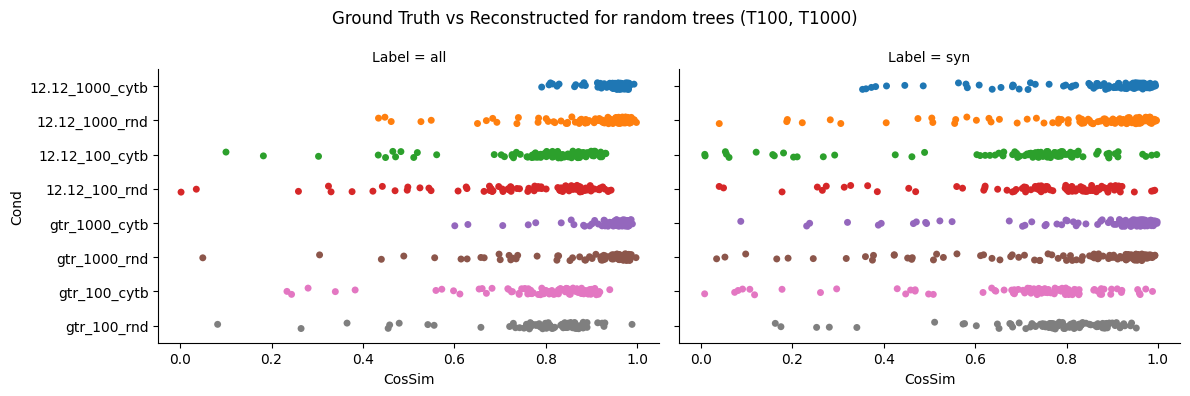

In [47]:
g = sns.catplot(x="CosSim", y="Cond", col="Label",
                data=sims, kind="strip",
                height=4, aspect=1.5);
g.fig.suptitle("Ground Truth vs Reconstructed for random trees (T100, T1000)")
g.fig.subplots_adjust(top=0.83)
plt.show()

In [ ]:
cutoff = 0.95
sims[f"cossim > {cutoff}"] = sims.CosSim > cutoff
sims.groupby(["Cond", "Label"])[f"cossim > {cutoff}"].value_counts().unstack()

cossim > 0.95          False  True
Cond            Label             
12.12_1000_cytb all     34.0  66.0
                syn     63.0  37.0
12.12_1000_rnd  all     51.0  49.0
                syn     71.0  29.0
12.12_100_cytb  all    100.0   NaN
                syn     96.0   4.0
12.12_100_rnd   all     94.0   NaN
                syn     91.0   3.0
gtr_1000_cytb   all     25.0  75.0
                syn     56.0  44.0
gtr_1000_rnd    all     46.0  54.0
                syn     71.0  29.0
gtr_100_cytb    all    100.0   NaN
                syn     95.0   5.0
gtr_100_rnd     all     89.0   1.0
                syn     89.0   1.0

In [ ]:
cutoff = 0.85
sims[f"cossim > {cutoff}"] = sims.CosSim > cutoff
sims.groupby(["Cond", "Label"])[f"cossim > {cutoff}"].value_counts().unstack()

cossim > 0.85          False  True
Cond            Label             
12.12_1000_cytb all        6    94
                syn       27    73
12.12_1000_rnd  all       21    79
                syn       39    61
12.12_100_cytb  all       64    36
                syn       87    13
12.12_100_rnd   all       58    36
                syn       67    27
gtr_1000_cytb   all        6    94
                syn       27    73
gtr_1000_rnd    all       20    80
                syn       40    60
gtr_100_cytb    all       63    37
                syn       83    17
gtr_100_rnd     all       57    33
                syn       65    25

### Similarity by observed mutation counts

In [27]:
sims = get_cossim(obs_gt_wide, obs_rec_wide).rename("CosSim").reset_index()
sims["Cond"] = sims.RawCond.str.replace("_replica_\d{1,2}", "")
sims.head()

,RawCond,Label,CosSim,Cond
0,12.12_1000_cytb_replica_0,all,0.999845,12.12_1000_cytb
1,12.12_1000_cytb_replica_0,syn,0.999496,12.12_1000_cytb
2,12.12_1000_cytb_replica_1,all,0.999924,12.12_1000_cytb
3,12.12_1000_cytb_replica_1,syn,0.999687,12.12_1000_cytb
4,12.12_1000_cytb_replica_10,all,0.999878,12.12_1000_cytb


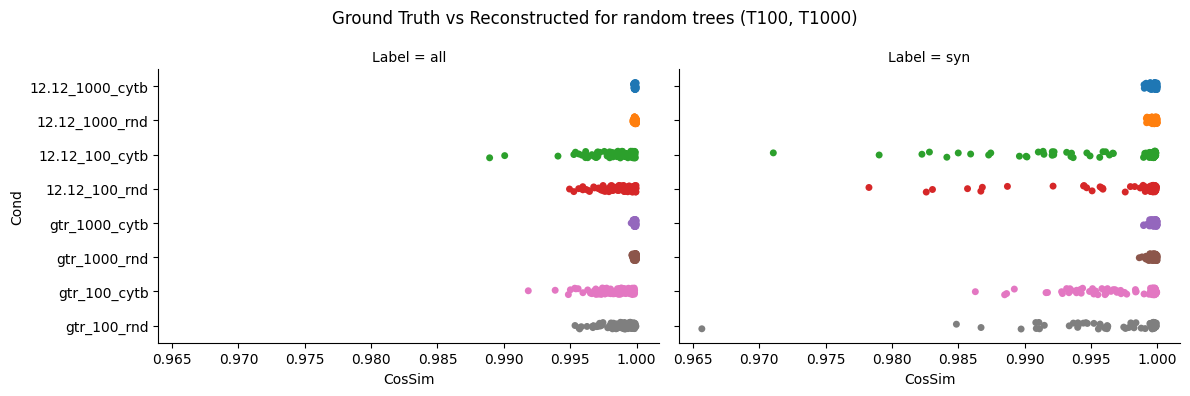

In [30]:
g = sns.catplot(x="CosSim", y="Cond", col="Label",
                data=sims, kind="strip",
                height=4, aspect=1.5);
g.fig.suptitle("Ground Truth vs Reconstructed for random trees (T100, T1000)")
g.fig.subplots_adjust(top=0.83)
plt.show()